<h1> Bước 1: </h1> Cài đặt thư viện và chương trình

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from keras.models import load_model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM, Dense
from keras.utils.vis_utils import plot_model

<h1> Bước 2:</h1> Sử dụng, khai thác thông tin dữ liệu

In [2]:
data = pd.read_csv('Data.csv', na_values=['null'], index_col='Date', parse_dates=True)

In [3]:
print(f"Số lượng dữ liệu: {data.shape[0]}x{data.shape[1]}")

Số lượng dữ liệu: 3776x6


In [4]:
data.drop(["Adj Close"], axis=1, inplace=True)
data.head() # 5 dòng đầu

,Open,High,Low,Close,Volume
Date,,,,,
2003-12-31,4.045714,4.091429,3.880714,3.906429,16801400
2004-01-02,4.107143,4.127857,3.842143,3.916429,50230600
2004-01-05,3.892857,4.061429,3.875000,3.992857,25207000
2004-01-06,3.946429,4.339286,3.937143,4.257857,52633000
2004-01-07,4.307143,4.470000,4.249286,4.445714,68432000


In [5]:
data.info() # Thông tin của từng cột dữ liệu

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3776 entries, 2003-12-31 to 2018-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3776 non-null   float64
 1   High    3776 non-null   float64
 2   Low     3776 non-null   float64
 3   Close   3776 non-null   float64
 4   Volume  3776 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 177.0 KB


In [6]:
data.describe() # Thông tin từng cột dữ liệu

,Open,High,Low,Close,Volume
count,3776.000000,3776.000000,3776.000000,3776.000000,3.776000e+03
mean,56.653638,57.552998,55.681395,56.643953,1.918587e+07
std,85.461244,86.790599,83.904099,85.372837,2.074758e+07
min,1.300000,1.317143,1.272857,1.290000,1.493800e+06
25%,4.082857,4.156786,3.992857,4.094286,7.792225e+06
50%,15.432143,15.760714,15.046429,15.395000,1.297695e+07
75%,68.606428,69.155716,67.800713,68.397860,2.287355e+07
max,421.380005,423.209991,413.079987,418.970001,3.234140e+08


<h3> Tính tỷ suất lợi nhuận </h3>

In [7]:
Profit_Margin = pd.DataFrame() # DataFrame này có tác dụng dùng để chứa giá trị tỷ suất lợi nhuận cho từng ngày
Profit_Margin['Profit_Margin__Open'] = data['Open'].pct_change()
Profit_Margin['Profit_Margin__High'] = data['High'].pct_change()
Profit_Margin['Profit_Margin__Low'] = data['Low'].pct_change()
Profit_Margin['Profit_Margin__Close'] = data['Close'].pct_change()
Profit_Margin['Profit_Margin__Volume'] = data['Volume'].pct_change()
Profit_Margin = Profit_Margin.dropna()
Profit_Margin.head()

,Profit_Margin__Open,Profit_Margin__High,Profit_Margin__Low,Profit_Margin__Close,Profit_Margin__Volume
Date,,,,,
2004-01-02,0.015184,0.008903,-0.009939,0.002560,1.989668
2004-01-05,-0.052174,-0.016093,0.008552,0.019515,-0.498174
2004-01-06,0.013762,0.068414,0.016037,0.066369,1.088031
2004-01-07,0.091403,0.030123,0.079282,0.044120,0.300173
2004-01-08,0.053897,0.021093,0.009918,-0.002892,-0.456710


<h3>Trực quan hóa dữ liệu</h3>

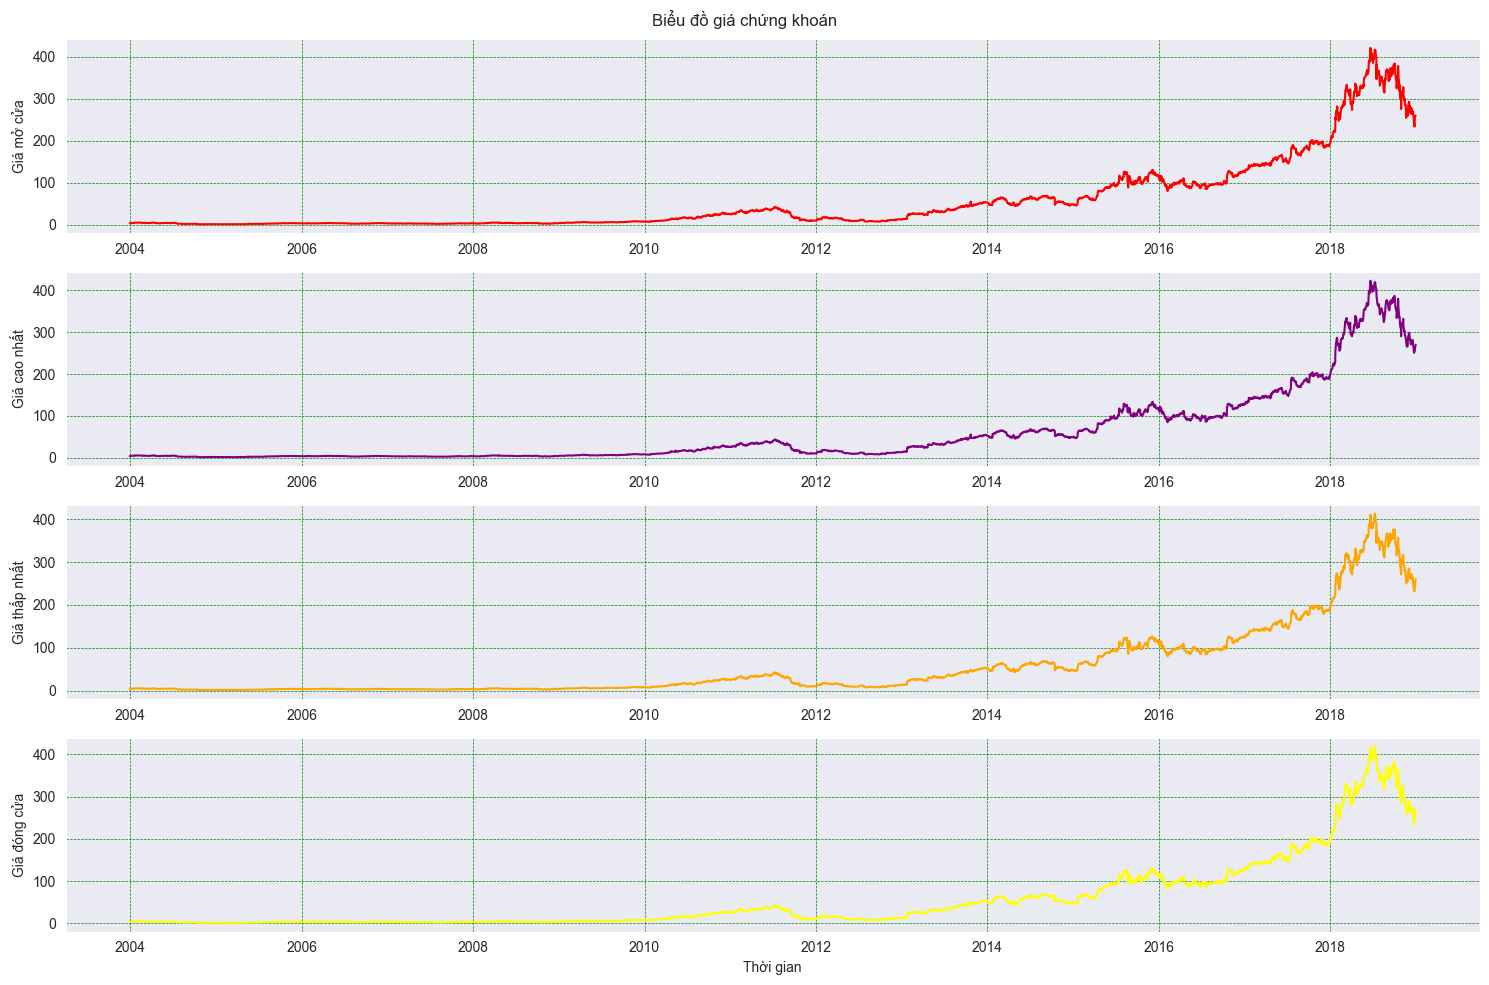

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10))

# Biểu đồ giá mở cửa
axs[0].plot(data['Open'], color="red")
axs[0].set_ylabel("Giá mở cửa")
axs[0].grid(color='green', linestyle='--', linewidth=0.5)

# Biểu đồ giá cao nhất
axs[1].plot(data['High'], color="purple")
axs[1].set_ylabel("Giá cao nhất")
axs[1].grid(color='green', linestyle='--', linewidth=0.5)

# Biểu đồ giá thấp nhất
axs[2].plot(data['Low'], color="orange")
axs[2].set_ylabel("Giá thấp nhất")
axs[2].grid(color='green', linestyle='--', linewidth=0.5)

# Biểu đồ giá đóng cửa
axs[3].plot(data['Close'], color="yellow")
axs[3].set_ylabel("Giá đóng cửa")
axs[3].grid(color='green', linestyle='--', linewidth=0.5)

# Đặt tiêu đề chung cho biểu đồ
fig.suptitle("Biểu đồ giá chứng khoán")

# Định dạng đồ thị
plt.xlabel("Thời gian")
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

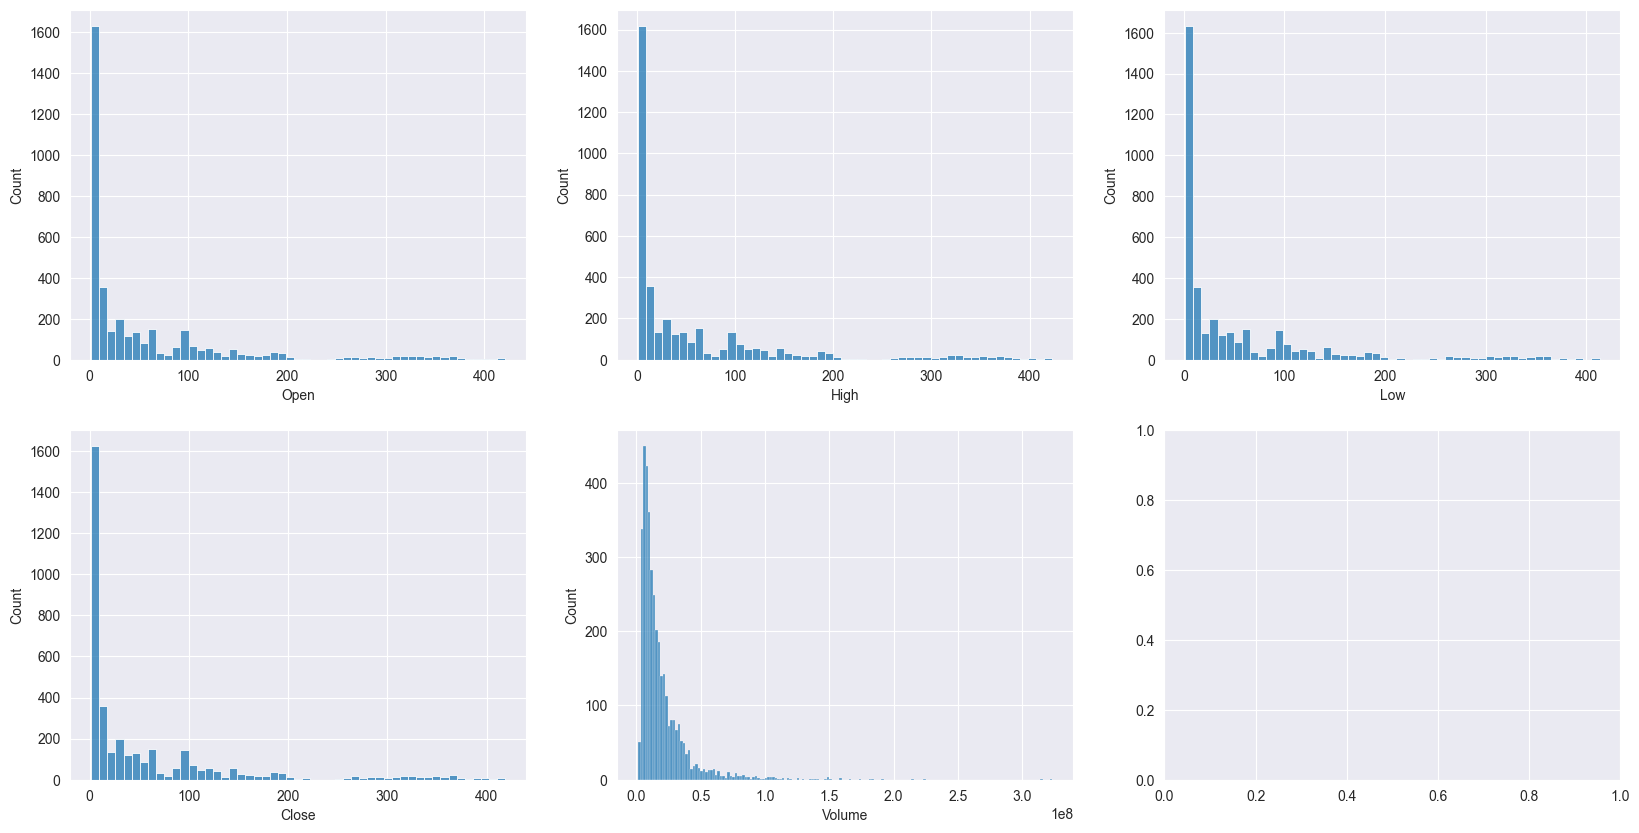

In [9]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, col in enumerate(features):
    sb.histplot(data[col], ax=axes[i // 3, i % 3])
plt.show()

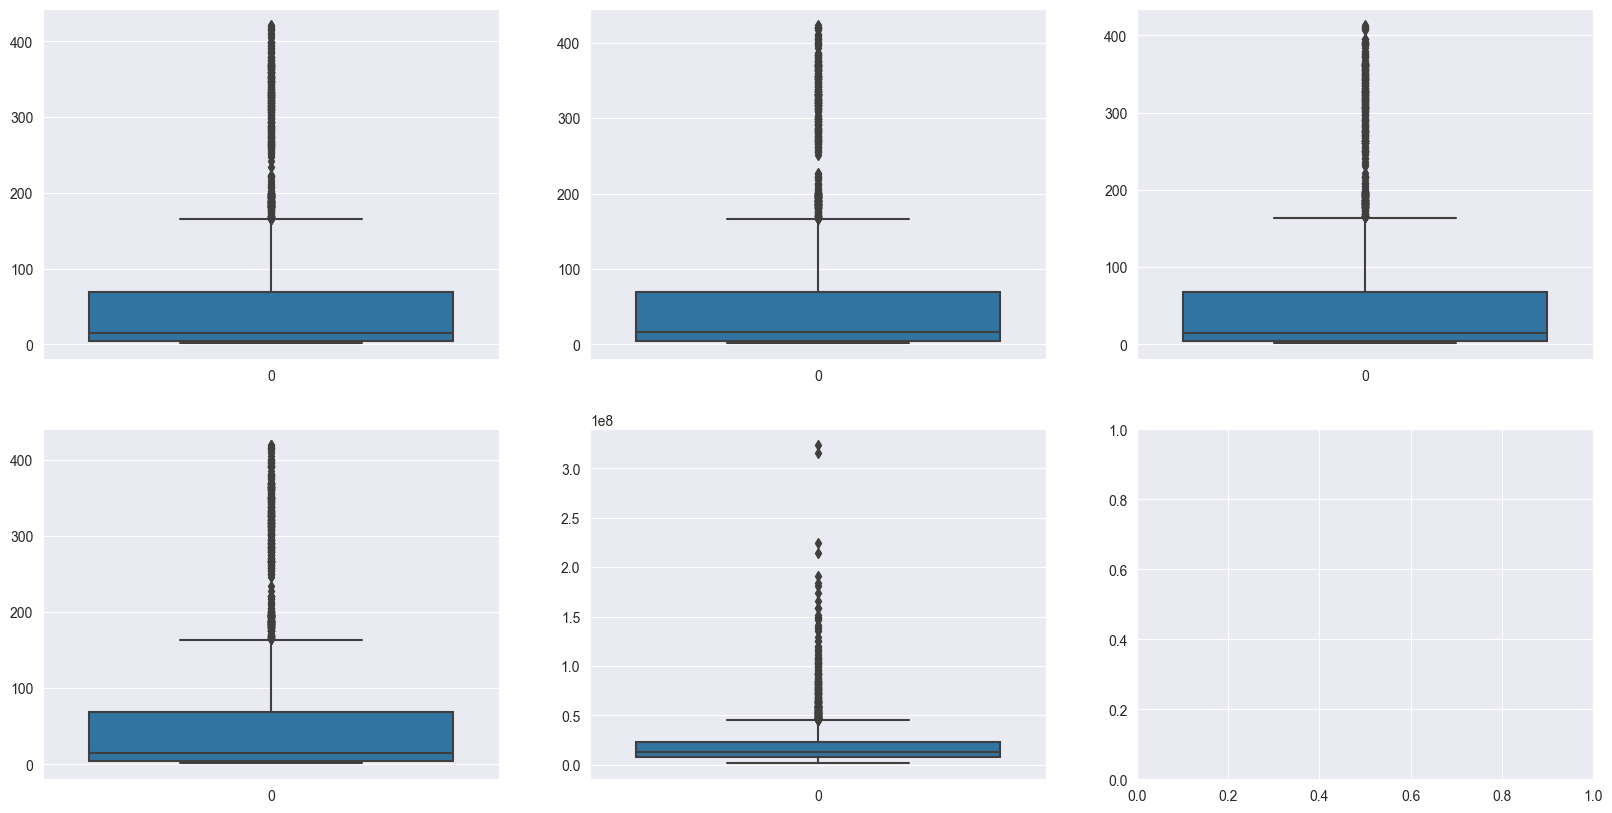

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, col in enumerate(features):
    sb.boxplot(data[col], ax=axes[i // 3, i % 3])
plt.show()

<h1> Bước 3:</h1> Sử dụng dữ liệu để thực hiện huấn luyện cho mô hình

<li>Sử dụng thông tin dữ liệu của giá 'High', 'Low', 'Close' và 'Volume' để dự đoán giá 'Open'</li>

In [11]:
features = ["High", "Low", "Close", "Volume"]
output_var = pd.DataFrame(data["Open"])

scaler = MinMaxScaler(feature_range=(0, 1))
feature_transform = scaler.fit_transform(data[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=data.index)

In [12]:
# Chia tập dữ liệu thành các tập train và test
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[1:len(train_index)+1].values.ravel(), output_var[len(train_index)+1: (len(train_index)+len(test_index)+1)].values.ravel()
    X_test = X_test[:-1]

In [13]:
# Chuyển đổi dữ liệu thành dạng phù hợp cho LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

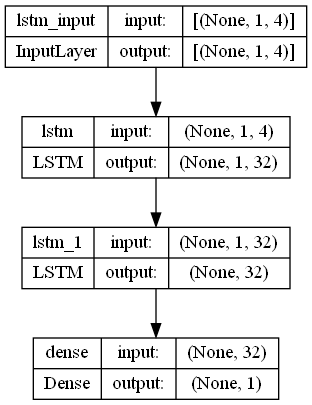

In [14]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
# Huấn luyện mô hình
save_model = 'Model/Model_Open.h5'
plot_model(model, show_shapes=True, show_layer_names=True)
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=1, save_best_only=True, mode='auto')
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, callbacks=[best_model])

Epoch 1/100
394/430 [==========================>...] - ETA: 0s - loss: 2065.8445
Epoch 1: loss improved from inf to 1948.81726, saving model to Model\Model_Open.h5
430/430 [==============================] - 3s 2ms/step - loss: 1948.8173
Epoch 2/100
395/430 [==========================>...] - ETA: 0s - loss: 252.8498
Epoch 2: loss improved from 1948.81726 to 240.27319, saving model to Model\Model_Open.h5
430/430 [==============================] - 1s 1ms/step - loss: 240.2732
Epoch 3/100
411/430 [===========================>..] - ETA: 0s - loss: 57.5091
Epoch 3: loss improved from 240.27319 to 57.03104, saving model to Model\Model_Open.h5
430/430 [==============================] - 1s 2ms/step - loss: 57.0310
Epoch 4/100
409/430 [===========================>..] - ETA: 0s - loss: 33.8317
Epoch 4: loss improved from 57.03104 to 33.40046, saving model to Model\Model_Open.h5
430/430 [==============================] - 1s 1ms/step - loss: 33.4005
Epoch 5/100
412/430 [===========================>

Kết quả (MSE): 109.64055633544922
11/11 [==============================] - 0s 2ms/step
R₂:  0.9788387579286177
MAE:  7.542114123626531
MAPE:  0.0236005556821623 %


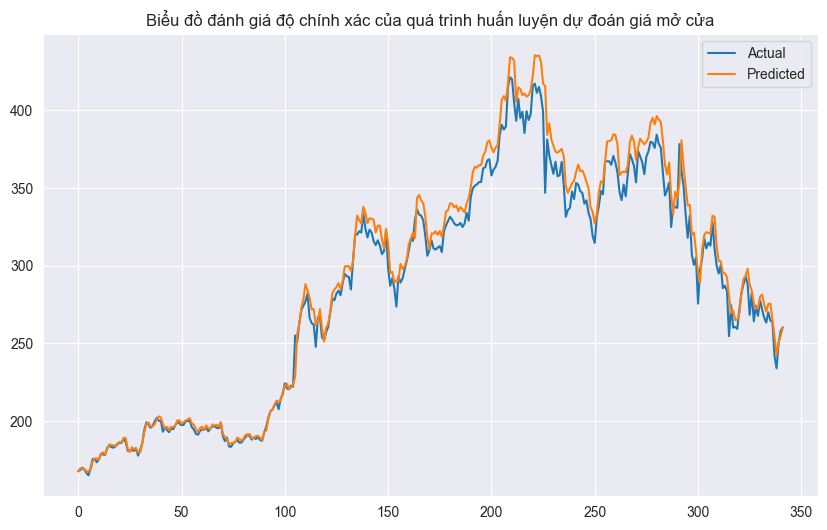

In [16]:
# Đánh giá độ chính xác trên tập kiểm tra
loss = model.evaluate(X_test, y_test, verbose=0)
print("Kết quả (MSE):", loss) # Lỗi bình phương trung bình trên bộ TEST
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("R₂: ", r2) # Độ chính xác của tập Train (R2 Score)
print("MAE: ", mae) # Sai số tuyệt đối trung bình của tập Train (Mean Absolute Error)
print("MAPE: ", mape , "%") # Phần trăm sai số tuyệt đối trung bình của tập Train (Mean Absolute Percentage Error)

# Vẽ biểu đồ đánh giá độ chính xác
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Biểu đồ đánh giá độ chính xác của quá trình huấn luyện dự đoán giá mở cửa')
plt.legend()
plt.show()

<li>Sử dụng thông tin dữ liệu của giá 'Open', 'Low', 'Close' và 'Volume' để dự đoán giá 'High'</li>

In [19]:
features = ["Open", "Low", "Close", "Volume"]
output_var = pd.DataFrame(data["High"])

scaler = MinMaxScaler(feature_range=(0, 1))
feature_transform = scaler.fit_transform(data[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=data.index)

In [20]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[1:len(train_index)+1].values.ravel(), output_var[len(train_index)+1: (len(train_index)+len(test_index)+1)].values.ravel()
    X_test = X_test[:-1]

In [21]:
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

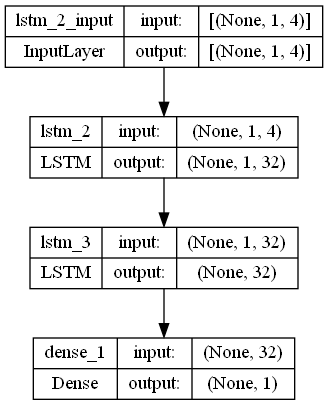

In [22]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
plot_model(model, show_shapes=True, show_layer_names=True)

In [23]:
save_model = 'Model/Model_High.h5'
plot_model(model, show_shapes=True, show_layer_names=True)
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=1, save_best_only=True, mode='auto')
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, callbacks=[best_model])

Epoch 1/100
401/430 [==========================>...] - ETA: 0s - loss: 2154.0769
Epoch 1: loss improved from inf to 2068.48096, saving model to Model\Model_High.h5
430/430 [==============================] - 3s 2ms/step - loss: 2068.4810
Epoch 2/100
412/430 [===========================>..] - ETA: 0s - loss: 224.3083
Epoch 2: loss improved from 2068.48096 to 216.59607, saving model to Model\Model_High.h5
430/430 [==============================] - 1s 1ms/step - loss: 216.5961
Epoch 3/100
410/430 [===========================>..] - ETA: 0s - loss: 13.9547
Epoch 3: loss improved from 216.59607 to 13.52939, saving model to Model\Model_High.h5
430/430 [==============================] - 1s 2ms/step - loss: 13.5294
Epoch 4/100
416/430 [============================>.] - ETA: 0s - loss: 4.0006
Epoch 4: loss improved from 13.52939 to 3.98756, saving model to Model\Model_High.h5
430/430 [==============================] - 1s 2ms/step - loss: 3.9876
Epoch 5/100
426/430 [============================>.]

Kết quả (MSE): 170.5045166015625
11/11 [==============================] - 0s 1ms/step
R₂:  0.9681299139872993
MAE:  9.851070565047058
MAPE:  0.030222672334708416 %


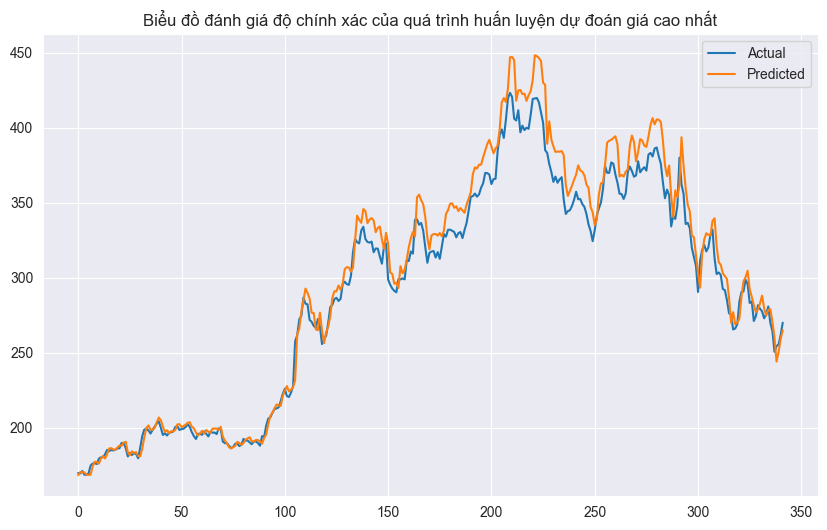

In [24]:
loss = model.evaluate(X_test, y_test, verbose=0)
print("Kết quả (MSE):", loss)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("R₂: ", r2)
print("MAE: ", mae)
print("MAPE: ", mape , "%")
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Biểu đồ đánh giá độ chính xác của quá trình huấn luyện dự đoán giá cao nhất')
plt.legend()
plt.show()

<li>Sử dụng thông tin dữ liệu của giá 'Open', 'High', 'Close' và 'Volume' để dự đoán giá 'Low'</li>

In [27]:
features = ["Open", "High", "Close", "Volume"]
output_var = pd.DataFrame(data["Low"])

scaler = MinMaxScaler(feature_range=(0, 1))
feature_transform = scaler.fit_transform(data[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=data.index)

In [28]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[1:len(train_index)+1].values.ravel(), output_var[len(train_index)+1: (len(train_index)+len(test_index)+1)].values.ravel()
    X_test = X_test[:-1]

In [29]:
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

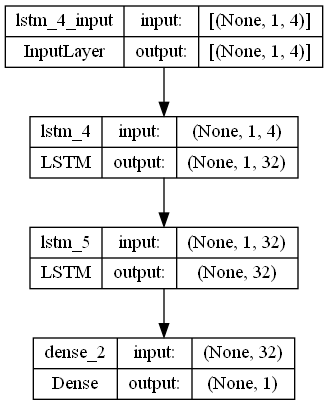

In [30]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
plot_model(model, show_shapes=True, show_layer_names=True)

In [31]:
save_model = 'Model/Model_Low.h5'
plot_model(model, show_shapes=True, show_layer_names=True)
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=1, save_best_only=True, mode='auto')
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, callbacks=[best_model])

Epoch 1/100
409/430 [===========================>..] - ETA: 0s - loss: 1971.8040
Epoch 1: loss improved from inf to 1912.62512, saving model to Model\Model_Low.h5
430/430 [==============================] - 3s 1ms/step - loss: 1912.6251
Epoch 2/100
401/430 [==========================>...] - ETA: 0s - loss: 204.2063
Epoch 2: loss improved from 1912.62512 to 192.90388, saving model to Model\Model_Low.h5
430/430 [==============================] - 1s 1ms/step - loss: 192.9039
Epoch 3/100
407/430 [===========================>..] - ETA: 0s - loss: 14.0382
Epoch 3: loss improved from 192.90388 to 13.77256, saving model to Model\Model_Low.h5
430/430 [==============================] - 1s 1ms/step - loss: 13.7726
Epoch 4/100
401/430 [==========================>...] - ETA: 0s - loss: 4.9284
Epoch 4: loss improved from 13.77256 to 4.74055, saving model to Model\Model_Low.h5
430/430 [==============================] - 1s 1ms/step - loss: 4.7405
Epoch 5/100
407/430 [===========================>..] - E

Kết quả (MSE): 407.5684509277344
11/11 [==============================] - 0s 1ms/step
R₂:  0.9172878371937427
MAE:  15.839243051632174
MAPE:  0.051153285160800595 %


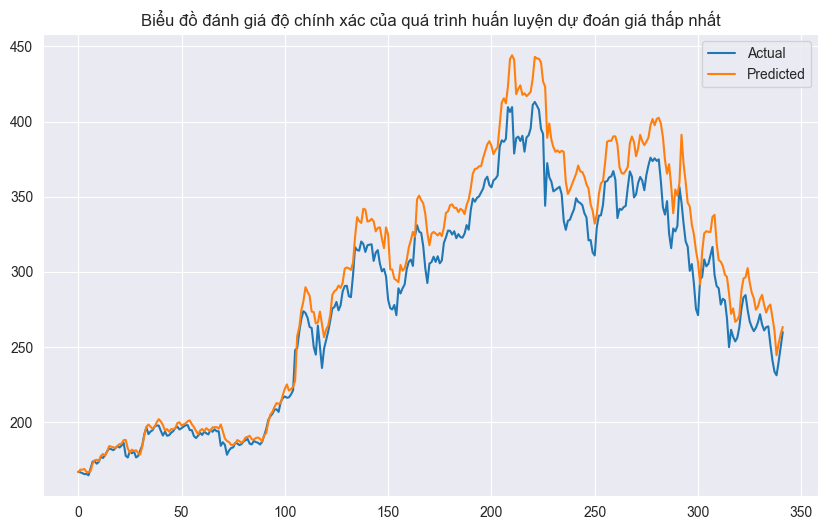

In [32]:
loss = model.evaluate(X_test, y_test, verbose=0)
print("Kết quả (MSE):", loss)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("R₂: ", r2)
print("MAE: ", mae)
print("MAPE: ", mape , "%")
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Biểu đồ đánh giá độ chính xác của quá trình huấn luyện dự đoán giá thấp nhất')
plt.legend()
plt.show()

<li>Sử dụng thông tin dữ liệu của giá 'Open', 'High', 'Low' và 'Volume' để dự đoán giá 'Close'</li>

In [35]:
features = ["Open", "High", "Low", "Volume"]
output_var = pd.DataFrame(data["Close"])

scaler = MinMaxScaler(feature_range=(0, 1))
feature_transform = scaler.fit_transform(data[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=data.index)

In [36]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[1:len(train_index)+1].values.ravel(), output_var[len(train_index)+1: (len(train_index)+len(test_index)+1)].values.ravel()
    X_test = X_test[:-1]

In [37]:
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

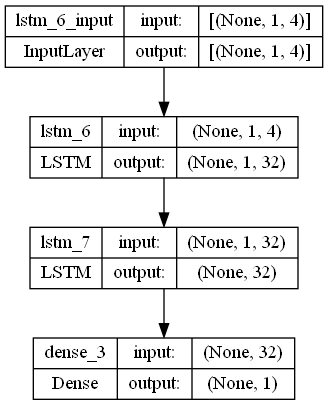

In [38]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation="relu", return_sequences=True))
model.add(LSTM(32, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
plot_model(model, show_shapes=True, show_layer_names=True)

In [39]:
save_model = 'Model/Model_Close.h5'
plot_model(model, show_shapes=True, show_layer_names=True)
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=1, save_best_only=True, mode='auto')
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, callbacks=[best_model])

Epoch 1/100
411/430 [===========================>..] - ETA: 0s - loss: 2092.3164
Epoch 1: loss improved from inf to 2041.12195, saving model to Model\Model_Close.h5
430/430 [==============================] - 2s 2ms/step - loss: 2041.1219
Epoch 2/100
408/430 [===========================>..] - ETA: 0s - loss: 236.0804
Epoch 2: loss improved from 2041.12195 to 226.04608, saving model to Model\Model_Close.h5
430/430 [==============================] - 1s 1ms/step - loss: 226.0461
Epoch 3/100
401/430 [==========================>...] - ETA: 0s - loss: 13.0750
Epoch 3: loss improved from 226.04608 to 12.54698, saving model to Model\Model_Close.h5
430/430 [==============================] - 1s 2ms/step - loss: 12.5470
Epoch 4/100
401/430 [==========================>...] - ETA: 0s - loss: 4.5203
Epoch 4: loss improved from 12.54698 to 4.43502, saving model to Model\Model_Close.h5
430/430 [==============================] - 1s 1ms/step - loss: 4.4350
Epoch 5/100
411/430 [===========================

Kết quả (MSE): 203.3869171142578
11/11 [==============================] - 0s 1ms/step
R₂:  0.9603375082109562
MAE:  10.516651630927907
MAPE:  0.034141859029321917 %


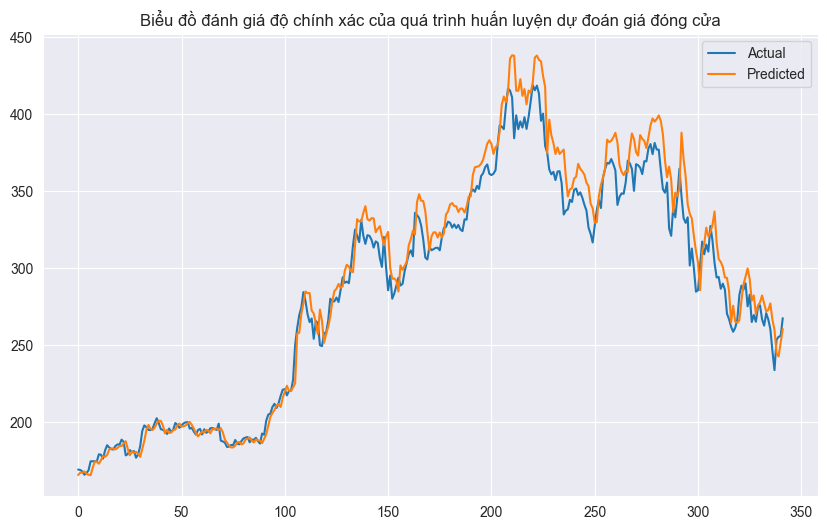

In [40]:
loss = model.evaluate(X_test, y_test, verbose=0)
print("Kết quả (MSE):", loss)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("R₂: ", r2)
print("MAE: ", mae)
print("MAPE: ", mape , "%")
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Biểu đồ đánh giá độ chính xác của quá trình huấn luyện dự đoán giá đóng cửa')
plt.legend()
plt.show()

<h1> Bước 4:</h1> Kiểm thử kết quả của quá huấn luyện

In [18]:
# Kiểm thử kết quả từ model huấn luyện
loaded_model = load_model('Model/Model_Open.h5')
# Nhập giá trị mới
high_value = float(input("Hãy nhập giá cao nhất: "))
low_value = float(input("Hãy nhập giá thấp nhất: "))
close_value = float(input("Hãy nhập giá đóng cửa: "))
volume_value = float(input("Hãy nhập khối lượng giao dịch: "))

# Chuẩn hóa đặc trưng mới
new_features = scaler.transform([[high_value, low_value, close_value, volume_value]])
new_features = pd.DataFrame(columns=features, data=new_features)

# Chuyển đổi dữ liệu mới thành dạng phù hợp cho LSTM
new_data = np.array(new_features)
new_data = new_data.reshape(new_data.shape[0], 1, new_data.shape[1])
predicted_adj_close = model.predict(new_data)
# In kết quả dự đoán
print("Kết quả giá mở cửa (Dự đoán) cho ngày mai:", predicted_adj_close)

1/1 [==============================] - 0s 18ms/step
Kết quả giá mở cửa (Dự đoán) cho ngày mai: [[254.73462]]


D:\Tu_Hoc_Lap_Trinh\Python\Major_Assignment\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [26]:
loaded_model = load_model('Model/Model_High.h5')
# Nhập giá trị mới
open_value = float(input("Hãy nhập giá mở cửa: "))
low_value = float(input("Hãy nhập giá thấp nhất: "))
close_value = float(input("Hãy nhập giá đóng cửa: "))
volume_value = float(input("Hãy nhập khối lượng giao dịch: "))

# Chuẩn hóa đặc trưng mới
new_features = scaler.transform([[open_value, low_value, close_value, volume_value]])
new_features = pd.DataFrame(columns=features, data=new_features)

# Chuyển đổi dữ liệu mới thành dạng phù hợp cho LSTM
new_data = np.array(new_features)
new_data = new_data.reshape(new_data.shape[0], 1, new_data.shape[1])
predicted_adj_close = model.predict(new_data)
# In kết quả dự đoán
print("Kết quả giá cao nhất (Dự đoán) cho ngày mai:", predicted_adj_close)

1/1 [==============================] - 0s 18ms/step
Kết quả giá cao nhất (Dự đoán) cho ngày mai: [[243.80441]]


D:\Tu_Hoc_Lap_Trinh\Python\Major_Assignment\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [34]:
loaded_model = load_model('Model/Model_Low.h5')
# Nhập giá trị mới
open_value = float(input("Hãy nhập giá mở cửa: "))
high_value = float(input("Hãy nhập giá cao nhất: "))
close_value = float(input("Hãy nhập giá đóng cửa: "))
volume_value = float(input("Hãy nhập khối lượng giao dịch: "))

# Chuẩn hóa đặc trưng mới
new_features = scaler.transform([[open_value, high_value, close_value, volume_value]])
new_features = pd.DataFrame(columns=features, data=new_features)

# Chuyển đổi dữ liệu mới thành dạng phù hợp cho LSTM
new_data = np.array(new_features)
new_data = new_data.reshape(new_data.shape[0], 1, new_data.shape[1])
predicted_adj_close = model.predict(new_data)
# In kết quả dự đoán
print("Kết quả giá thấp nhất (Dự đoán) cho ngày mai:", predicted_adj_close)

1/1 [==============================] - 0s 17ms/step
Kết quả giá cao nhất (Dự đoán) cho ngày mai: [[263.3548]]


D:\Tu_Hoc_Lap_Trinh\Python\Major_Assignment\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [42]:
loaded_model = load_model('Model/Model_Close.h5')
# Nhập giá trị mới
open_value = float(input("Hãy nhập giá mở cửa: "))
high_value = float(input("Hãy nhập giá cao nhất: "))
low_value = float(input("Hãy nhập giá thấp nhất: "))
volume_value = float(input("Hãy nhập khối lượng giao dịch: "))

# Chuẩn hóa đặc trưng mới
new_features = scaler.transform([[open_value, high_value, low_value, volume_value]])
new_features = pd.DataFrame(columns=features, data=new_features)

# Chuyển đổi dữ liệu mới thành dạng phù hợp cho LSTM
new_data = np.array(new_features)
new_data = new_data.reshape(new_data.shape[0], 1, new_data.shape[1])
predicted_adj_close = model.predict(new_data)
# In kết quả dự đoán
print("Kết quả giá đóng cửa (Dự đoán) cho ngày mai:", predicted_adj_close)

1/1 [==============================] - 0s 17ms/step
Kết quả giá thấp nhất (Dự đoán) cho ngày mai: [[260.64587]]


D:\Tu_Hoc_Lap_Trinh\Python\Major_Assignment\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
